# Reach-Scale Modeling Analysis

This Notebook covers preliminary analysis for the design of a simple reach-scale model in TempEst-NEWT/NEXT.

The reach model aims to be as simple as possible while achieving two goals with reasonable accuracy:

- General goal: allow efficient estimation of reach temperature profiles, particularly downstream of observation points or disturbances such as reservoirs.  (Thus, it must be possible to provide arbitrary upstream data, not just a NEWT model.)
- Specific goal: account for key in-channel fluxes such as solar radiation (riparian shading), evaporation, and general atmospheric heat exchange, which cannot be accounted for by a lumped watershed model.  This allows model users to analyze key reach-scale phenomena.

It is anticipated that this can be achieved with a simple equilibrium model, where (for water temperature $T$ and air temperature $T_a$ in C, time $t$, and fitting coefficients $A,~B$):

$$
    \frac{dT}{dt} = A(T_a-T) + B
$$

The fitting coefficient $A$ lumps together a variety of influences on sensible heat flux, such as channel depth.  The fitting coefficient $B$ parametrizes a number of effects where their variation with stream temperature probably cannot be estimated for an ungaged watershed, and which are therefore assumed to be constant (with respect to temperature, not time).  These include, chiefly, solar radiation, evaporation, and lateral/groundwater inflows.

For model training purposes, we do not have densely-spaced observations, and it is necessary to apply uniform coefficients.  Over long distances, applying the above equation linearly would result in substantial error, so we use an exponential solution:

$$
    T - T_a = C\exp(-At) + Bt \implies T = C\exp(-At) + Bt + T_a \implies \Delta T = T_0-T = (C + T_a) - (C\exp(-At) + Bt + T_a) = C(1-\exp(-At)) - Bt
$$

Such that:

- If $B$ is zero, $T$ exponentially decays towards $T_a$
- C = $T-T_a$ at the initial step
- A and B are fitted

A further necessity is to estimate the travel time over a reach, $t$.  With uniform flow, we can begin from Manning's equation, $v=\frac1n R^{2/3}S^{1/2}$ (for velocity $v$, roughness $n$, hydraulic radius $R$, and slope $S$).  Assuming - somewhat dubiously, but of necessity without coupling a hydrologic model - that $R$ has a power-law relationship to flow $Q$, which in turn has a power law relationship to the product of drainage area $D$ and precipitation $P$, we have $v=\frac1{\alpha}\frac1n(DP)^{\beta}S^{1/2}$ for fitting coefficients $\alpha,~\beta$.  Thus, for reach length $L$ and fitting coefficient 

$$
    t = \frac{\alpha Ln}{(DP)^{\beta}\sqrt{S}}
$$

Now, for the CONUS, we can get $n$, $L$, $S$ from NHDPlus Value Added Attributes, and only need to estimate $\alpha,~\beta$.

Note that for fitting a single river, those are all constant, so we (introducing a few more fitting coefficients, because we don't have enough to keep track of) simply have $t=\frac{k}{(DP)^q}$, and therefore need to fit $A,~B,~k,~q$ (we have an analytic solution for $C$).  Fitting four coefficients is pretty easy with a reasonably long timeseries, and since we're using a simple analytic solution, we can very quickly calculate tons of permutations and identify a rock-solid optimum.  If our assumptions are sufficiently decent, of course.

Now, how do we get the training data?  We want to use the reach model to capture details that the lumped model can't, so we're going to train off of USGS observations, which is why we can't get high-resolution training data.  But we do want our training data to represent a range of reach lengths, so we don't miss long-range or short-range effects.  So, over the 900ish development gages, we:

1. Set a random reach length as an integer kilometer between 1-100 km, uniformly distributed on a log scale (i.e., 1, 10, 100 not 1, 50, 100).  Longer than 100 km is past what would likely be of interest, and far too long to be anything like uniform; shorter than 1 km is getting into the range where detailed hydrology and hydraulics inaccessible to NEXT would be important.  Note that it'll be necessary to check the actual mainstem length, since some sites may have less than 100 km upstream.  I am going to arbitrarily set the maximum length to be 10% of the mainstem, so that most flow comes from the upper watershed; otherwise our Q~AP assumption would be even more problematic.
2. Compute flow time in the reach.
3. Compute the "no-reach" temperature as the area-weighted mean of all contributing watershed temperatures, with the timestep offset if flow time is more than half a day.
4. Compute the "missing" temperature as the difference between observed and no-reach temperature.
5. Using the first 70% of the available timeseries, calibrate the reach model coefficients to the "missing" temperature.
6. Test that solution on the final 30%.
7. Develop coefficient estimation.

Using what we've derived above, the final solution for reachwise *change in temperature* is:

$$
    \Delta T =  (T_0-T_a)\left(1-\exp\left(-\frac{Ak}{(DP)^q}\right)\right) - \frac{Bk}{(DP)^q}
$$

Note that $k$, $q$ are constants, while $A$ varies with discharge and $B$ with... everything.

Also note that the precipitation-area assumption *does not* work during major snowfall and snowmelt.  I'm not sure how to handle that.  In training, we can just use observed flow and only fit $A,~B$, but in prediction it gets difficult.

Before beginning the full process above, I will use a single test reach to evaluate model design and make sure it works, generally.

In [1]:
from NEXT import NEXT
import NEXT.data as data
import dataretrieval.nwis as nwis
import pandas as pd
import os
bp = "/scratch/dphilippus/notebooks/reach_analysis/"

# Single Watershed

## Prepare Data

In [2]:
raw_id = "394220106431500" # Eagle River
site = f"usgs:{raw_id}"  
dist = 5
buffer = 100
(trib, up, main) = data.get_upstream(site, dist)

<Axes: >

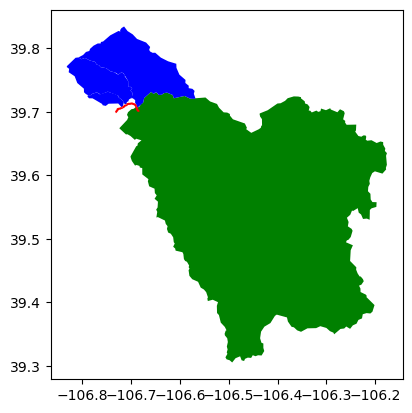

In [3]:
ax = up.plot(color="green")
trib.plot(ax=ax, color="blue")
main.plot(ax=ax, color="red")

In [10]:
path = bp + f"inputs_{raw_id}.csv"
if os.path.exists(path):
    inputs = pd.read_csv(path)
else:
    inputs = data.all_data_reaches(site, dist, buffer, "2015-01-01", "2022-12-31", as_df=True)
    inputs.to_csv(path, index=False)
inputs["date"] = pd.to_datetime(inputs["date"])

In [11]:
inputs

,id,id_type,lat,lon,area,water,developed,barren,forest,shrubland,...,unknown,ice_snow,elev,slope,elev_min,date,tmax,prcp,srad,vp
0,1320218,tributary,39.707065,-106.717691,8.470004e+06,0.000000,0.013346,0.0,0.372540,0.574460,...,0.0,0.0,2577.6653,0.000143,2104.947266,2015-01-01,-4.588571,0.00,279.29428,163.96858
1,1320218,tributary,39.707065,-106.717691,8.470004e+06,0.000000,0.013346,0.0,0.372540,0.574460,...,0.0,0.0,2577.6653,0.000143,2104.947266,2015-01-02,-3.252857,0.00,295.00287,165.38284
2,1320218,tributary,39.707065,-106.717691,8.470004e+06,0.000000,0.013346,0.0,0.372540,0.574460,...,0.0,0.0,2577.6653,0.000143,2104.947266,2015-01-03,-3.497143,0.00,252.76428,209.40144
3,1320218,tributary,39.707065,-106.717691,8.470004e+06,0.000000,0.013346,0.0,0.372540,0.574460,...,0.0,0.0,2577.6653,0.000143,2104.947266,2015-01-04,-2.460000,0.00,262.84857,217.35571
4,1320218,tributary,39.707065,-106.717691,8.470004e+06,0.000000,0.013346,0.0,0.372540,0.574460,...,0.0,0.0,2577.6653,0.000143,2104.947266,2015-01-05,3.735714,0.00,250.40285,373.06714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14595,1318968,mainstem,39.699524,-106.731839,1.087126e+06,0.014892,0.228593,0.0,0.108712,0.331348,...,0.0,0.0,2107.6343,0.000269,2082.747314,2022-12-27,7.660000,11.41,198.67000,407.80000
14596,1318968,mainstem,39.699524,-106.731839,1.087126e+06,0.014892,0.228593,0.0,0.108712,0.331348,...,0.0,0.0,2107.6343,0.000269,2082.747314,2022-12-28,4.810000,9.16,175.22000,400.09000
14597,1318968,mainstem,39.699524,-106.731839,1.087126e+06,0.014892,0.228593,0.0,0.108712,0.331348,...,0.0,0.0,2107.6343,0.000269,2082.747314,2022-12-29,-0.270000,3.34,183.94000,255.94000
14598,1318968,mainstem,39.699524,-106.731839,1.087126e+06,0.014892,0.228593,0.0,0.108712,0.331348,...,0.0,0.0,2107.6343,0.000269,2082.747314,2022-12-30,-2.070000,5.23,198.73000,199.09000


In [12]:
subws = inputs[inputs["id_type"] != "mainstem"]

## Model No-Reach Temperature

In [13]:
nxmod = NEXT.from_pickle("bins/newt_nb/coefs.pickle")

In [18]:
inp_preds = subws.groupby("id").apply(lambda x: nxmod.run(x, reset=True, use_climate=False), include_groups=False).reset_index()

In [21]:
tot_area = inp_preds.groupby("id")["area"].agg("first").sum()
tot_area

1410681888.181103

In [22]:
noreach = inp_preds.assign(tmod = lambda x: x["temp.mod"] * x["area"] / tot_area).groupby("date", as_index=False)["tmod"].agg("sum")
noreach

,date,tmod
0,2015-01-01,1.639370
1,2015-01-02,1.655644
2,2015-01-03,1.597038
3,2015-01-04,1.444195
4,2015-01-05,1.579142
...,...,...
2915,2022-12-27,2.292841
2916,2022-12-28,2.540712
2917,2022-12-29,2.409797
2918,2022-12-30,1.754372


<Axes: xlabel='date'>

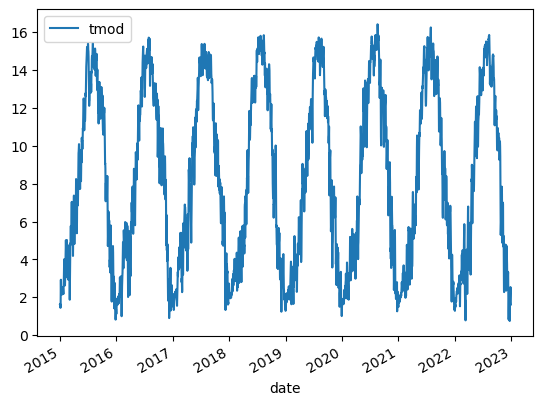

In [25]:
noreach.plot(x="date", y="tmod")

## Retrieve Observed Data and Compute Delta

In [35]:
tobs = nwis.get_dv(sites=[raw_id], start="2015-01-01", end="2022-12-31", parameterCd="00010")[0].assign(date=lambda x: pd.to_datetime(x.index.date))[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).dropna()
qobs = nwis.get_dv(sites=[raw_id], start="2015-01-01", end="2022-12-31", parameterCd="00060")[0].assign(date=lambda x: pd.to_datetime(x.index.date))[["date", "00060_Mean"]].rename(columns={"00060_Mean": "Q"}).dropna()

<Axes: xlabel='date'>

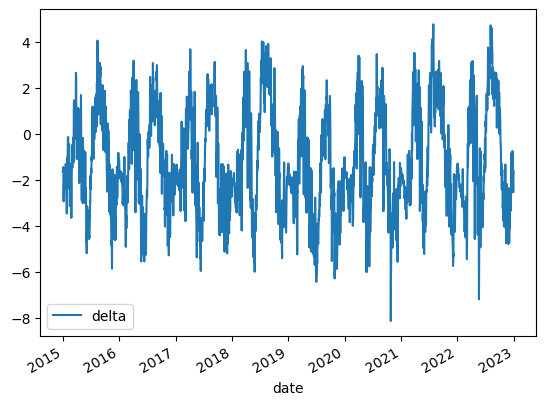

In [38]:
comb = noreach.merge(tobs, on="date").merge(qobs, on="date").assign(delta = lambda x: x["temperature"] - x["tmod"])
comb.plot(x="date", y="delta")

In [41]:
rivdat = inputs[inputs["id_type"] == "mainstem"]
fulldat = comb.merge(rivdat, on="date")
fulldat

,date,tmod,temperature,Q,delta,id,id_type,lat,lon,area,...,wetland,unknown,ice_snow,elev,slope,elev_min,tmax,prcp,srad,vp
0,2015-01-01,1.639370,0.0,104.0,-1.639370,1318968,mainstem,39.699524,-106.731839,1.087126e+06,...,0.313477,0.0,0.0,2107.6343,0.000269,2082.747314,-4.93,0.00,245.74,161.13
1,2015-01-02,1.655644,0.0,109.0,-1.655644,1318968,mainstem,39.699524,-106.731839,1.087126e+06,...,0.313477,0.0,0.0,2107.6343,0.000269,2082.747314,-3.56,0.00,262.08,160.61
2,2015-01-03,1.597038,0.0,110.0,-1.597038,1318968,mainstem,39.699524,-106.731839,1.087126e+06,...,0.313477,0.0,0.0,2107.6343,0.000269,2082.747314,-2.05,0.00,245.84,205.38
3,2015-01-04,1.444195,0.0,116.0,-1.444195,1318968,mainstem,39.699524,-106.731839,1.087126e+06,...,0.313477,0.0,0.0,2107.6343,0.000269,2082.747314,-2.04,0.00,233.32,223.37
4,2015-01-05,1.579142,0.0,124.0,-1.579142,1318968,mainstem,39.699524,-106.731839,1.087126e+06,...,0.313477,0.0,0.0,2107.6343,0.000269,2082.747314,5.10,0.00,243.90,364.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896,2022-12-27,2.292841,0.0,91.6,-2.292841,1318968,mainstem,39.699524,-106.731839,1.087126e+06,...,0.313477,0.0,0.0,2107.6343,0.000269,2082.747314,7.66,11.41,198.67,407.80
2897,2022-12-28,2.540712,0.0,89.7,-2.540712,1318968,mainstem,39.699524,-106.731839,1.087126e+06,...,0.313477,0.0,0.0,2107.6343,0.000269,2082.747314,4.81,9.16,175.22,400.09
2898,2022-12-29,2.409797,0.0,88.3,-2.409797,1318968,mainstem,39.699524,-106.731839,1.087126e+06,...,0.313477,0.0,0.0,2107.6343,0.000269,2082.747314,-0.27,3.34,183.94,255.94
2899,2022-12-30,1.754372,0.0,88.8,-1.754372,1318968,mainstem,39.699524,-106.731839,1.087126e+06,...,0.313477,0.0,0.0,2107.6343,0.000269,2082.747314,-2.07,5.23,198.73,199.09


## Fit Model

Recall:

$$
    \Delta T =  (T_0-T_a)\left(1-\exp\left(-\frac{A}{Q^q}\right)\right) - \frac{B}{Q^q}
$$

Modifications from above: replace $DP$ with $Q$ (observed), and note that the $k$, since it affects both $A$ and $B$ and is constant, can simply be lumped in to them.